# Google TimesFM model for predict today's tesla stock price (yejin)

- TimesFM (Time Series Foundation Model)
- reference 
: https://huggingface.co/google/timesfm-1.0-200m

* used python 3.11.11 in jupyter kernel on my mac

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from time import time
from datetime import date
import warnings
warnings.filterwarnings("ignore")

In [2]:
import timesfm
# For Torch 
tfm = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="gpu", # Specifies the hardware backend; options are "cpu" or "gpu" ,GPU can significantly speed up computations
          per_core_batch_size=64, # Larger batch sizes can improve training stability but may require more memory.
          horizon_len=30, #Determines the number of future time steps the model aims to predict.
          num_layers=30, # More layers can capture more complex patterns in the data but may lead to overfitting if not managed properly. 
          use_positional_embedding=False, 
          # For time-series data where the sequence order is crucial, 
          # enabling positional embeddings (True) can help the model understand temporal relationships better.
          context_len=1024, 
          #A longer context can provide more information but may also introduce more noise.
          # length of historical data (in time steps) the model uses to make predictions.
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
  )

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.11 (main, Jan 27 2025, 15:58:08) [Clang 16.0.0 (clang-1600.0.26.6)].


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

#optimize hyperparameter trial 

num_layers max : 50 
False > True
context_len >3000 : error
horizontal_len : 128->50 > can see the plot clearly 

In [3]:
# # For Torch
# tfm = timesfm.TimesFm(
#       hparams=timesfm.TimesFmHparams(
#           backend="gpu",
#           per_core_batch_size=32,
#           horizon_len=128,
#       ),
#       checkpoint=timesfm.TimesFmCheckpoint(
#           huggingface_repo_id="google/timesfm-1.0-200m-pytorch"),
#   )

# version 1.0 is worse than 2.0

In [4]:
# 1. Fetch stock data for TSLA
GetTSLA = yf.Ticker("TSLA")
TSLA_data=GetTSLA.history(period="max")
TSLA_data.reset_index(inplace=True)  # Reset index to make "Date" a column
TSLA_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0
1,2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0
2,2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0
3,2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0
4,2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0


### Autocorrelation Analysis for Period Selection

To determine the appropriate sampling periods for the time series model, I analyzed the **Autocorrelation Function (ACF)** of the data. I generated ACF plots for both the **original stock price data** and the **differenced version** to observe any significant lags or periodic patterns.

Based on the results, I tested multiple sampling intervals (e.g., **5-day, 7-day, and 10-day** intervals) to find an optimal resampling frequency for the model input.

Since the **TimesFM model does not require stationarity**, I decided to proceed with the **original (non-differenced) data** while keeping the selected sampling periods.


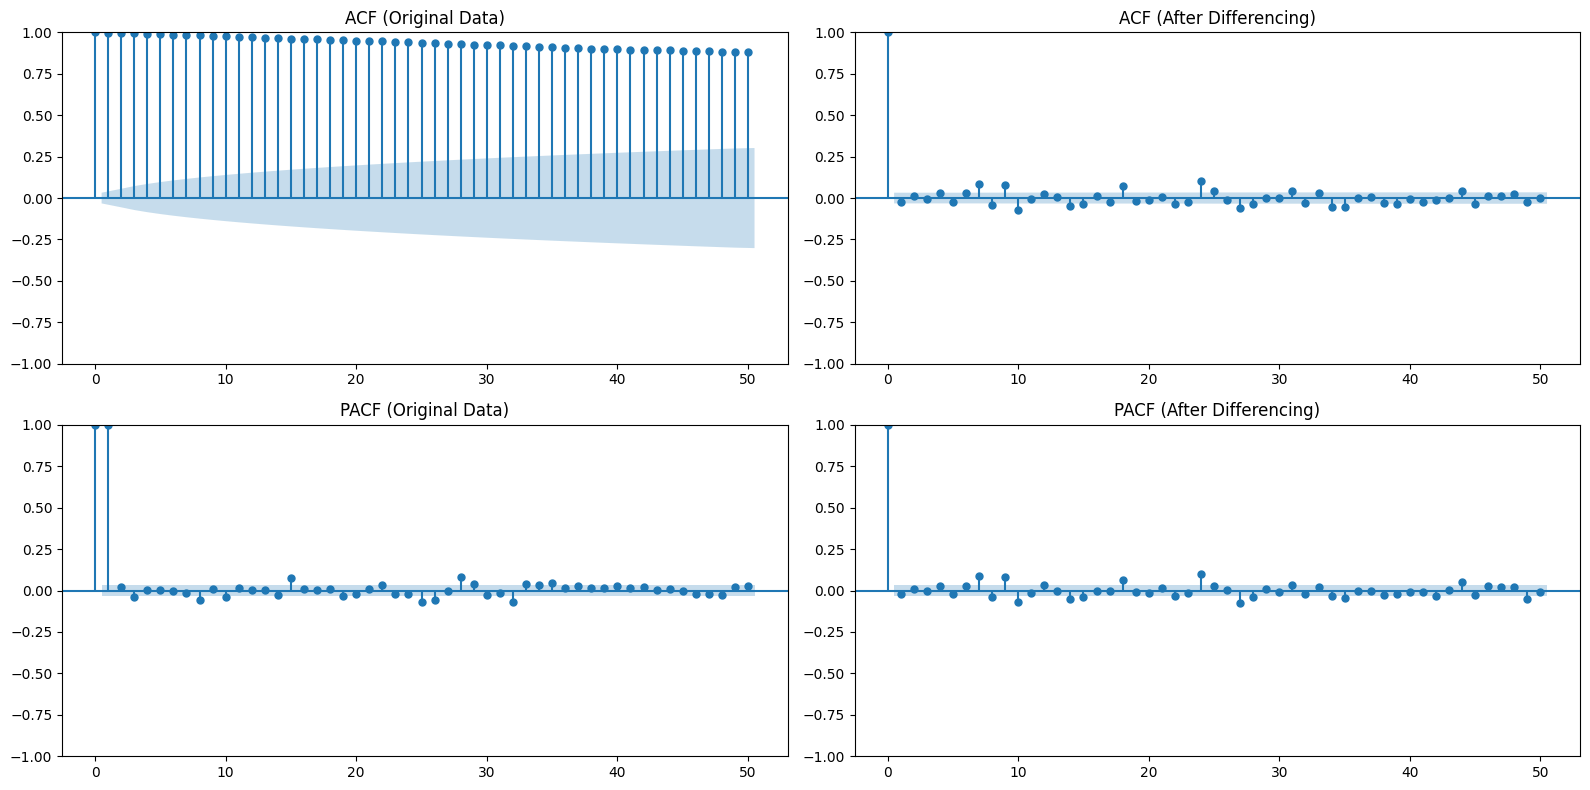

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

price = TSLA_data["Close"]
fig, axes = plt.subplots(2, 2, figsize=(16, 8))  
price_diff = price.diff().dropna()  

# 1. ACF for Original Data
plot_acf(price, lags=50, ax=axes[0, 0])
axes[0, 0].set_title("ACF (Original Data)")

# 2. ACF for Differenced Data
plot_acf(price_diff, lags=50, ax=axes[0, 1])
axes[0, 1].set_title("ACF (After Differencing)")

# 3. PACF for Original Data
plot_pacf(price, lags=50, ax=axes[1, 0], method="ywm")
axes[1, 0].set_title("PACF (Original Data)")

# 4. PACF for Differenced Data
plot_pacf(price_diff, lags=50, ax=axes[1, 1], method="ywm")
axes[1, 1].set_title("PACF (After Differencing)")

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Difference once')

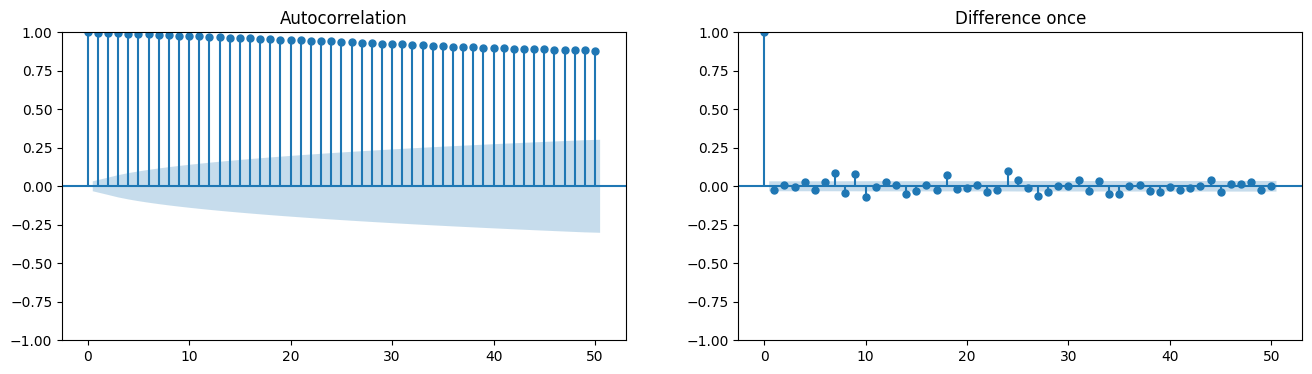

In [6]:
from statsmodels.graphics.tsaplots import plot_acf

price = TSLA_data["Close"]
fig, (ax1, ax2 ) = plt.subplots(1, 2, figsize=(16, 4))
price_diff = price.diff().dropna()


plot_acf(price, lags=50, ax=ax1)  # Check autocorrelation
plot_acf(price_diff, lags=50, ax=ax2)
ax2.set_title("Difference once")

In [7]:
# To check if the number of samples is enough
for days in [5, 7, 10, 14, 20]:
    print(f"Sampling every {days} days: {len(price.values[::days])} samples remaining")

Sampling every 5 days: 735 samples remaining
Sampling every 7 days: 525 samples remaining
Sampling every 10 days: 368 samples remaining
Sampling every 14 days: 263 samples remaining
Sampling every 20 days: 184 samples remaining


### 2. Prepare input data (resample and ensure 1D)

**Resampling** 

- The price.values[::N] syntax selects every Nth day from the price data, effectively resampling the dataset at different intervals (5, 7, and 10 days).
Flattening:

flatten() ensures that the resulting arrays are one-dimensional, which is often required for model input.
Equalizing Array Lengths:


- By resampling at various intervals, the model is exposed to patterns occurring at different frequencies, enhancing its ability to **learn both short-term fluctuations and long-term trends.** This diversity in training data can improve the model's robustness and predictive accuracy.

In [8]:
forecast_input = [
    np.array(price.values[::10]).flatten(),   # Every 5th day
    np.array(price.values[::5]).flatten(),  # Every 7th day
    np.array(price.values[::1]).flatten(),  # Every 10th day
]

#trial , 
5,7,10 -> 7,25,90 > no change

### 3. Ensure all arrays have the same length
To ensure consistency, all arrays are truncated to the length of the shortest array. This step is crucial for batch processing in models, where uniform input dimensions are necessary.
Purpose in Training:

min_length = min(len(arr) for arr in forecast_input)
forecast_input = [arr[:min_length] for arr in forecast_input]

### Determining of the frequency input
In particular regarding the frequency, TimesFM expects a categorical indicator valued in {0, 1, 2}:

- 0 (default): high frequency, long horizon time series. We recommend using this for time series up to daily granularity.
- 1: medium frequency time series. We recommend using this for weekly and monthly data.
- 2: low frequency, short horizon time series. We recommend using this for anything beyond monthly, e.g. quarterly or yearly.
This categorical value should be directly provided with the array inputs. For dataframe inputs, we convert the conventional letter coding of frequencies to our expected categories, that

0: T, MIN, H, D, B, U

1: W, M

2: Q, Y

In [9]:
# 4. Frequency input 
frequency_input = [2,1,0]

In [10]:
#5. Build input dataframe for TimesFM
# Create the dataframe in the format required by TimesFM
input_df = pd.DataFrame({
    "unique_id": ["TSLA"] * len(TSLA_data),  # Use "TSLA" as the unique identifier
    "ds": TSLA_data["Date"],                # Date column
    "y": TSLA_data["Close"]                 # Closing price
})

# 3. Ensure y values are 1-dimensional
# Flatten y to ensure it is a 1D array
input_df["y"] = input_df["y"].values.flatten()


# 6. Forecast using TimesFM
# Pass the input dataframe to the TimesFM model for forecasting
forecast_df = tfm.forecast_on_df(
    inputs=input_df,  # Input dataframe
    freq="D",         # Daily frequency
    value_name="y",   # The column to predict
    num_jobs=-1       # Use all available cores for parallel processing
)

# 7. Display forecast results
print(forecast_df)


Processing dataframe with multiple processes.


python(5633) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(5634) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(5635) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(5636) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(5637) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(5638) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(5639) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(5640) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.11 (main, Jan 27 2025, 15:58:08) [Clang 16.0.0 (clang-1600.0.26.6)].
Finished preprocessing dataframe.
Finished forecasting.
   unique_id                        ds     timesfm  timesfm-q-0.1  \
0       TSLA 2025-02-05 00:00:00-05:00  394.758301     372.721222   
1       TSLA 2025-02-06 00:00:00-05:00  394.661804     369.110809   
2       TSLA 2025-02-07 00:00:00-05:00  392.997772     363.298248   
3       TSLA 2025-02-08 00:00:00-05:00  393.033081     360.039215   
4       TSLA 2025-02-09 00:00:00-05:00  393.578796     356.719604   
5       TSLA 2025-02-10 00:00:00-05:00  391.056702     350.809570   
6       TSLA 2025-02-11 00:00:00-05:00  389.638367     346.484436   
7       TSLA 2025-02-12 00:00:00-05:00  389.351074     343.610291   
8       TSLA 2025-02-13 00:00:00-05:00  387.658142     338.741058   
9       TSLA 2025-02-14 00:00:00-05

In [11]:
point_forecast, experimental_quantile_forecast = tfm.forecast(
    forecast_input,
    freq=frequency_input,
)

In [12]:
point_forecast, experimental_quantile_forecast

(array([[342.6381 , 327.55612, 318.5499 , 304.32794, 299.27615, 292.90964,
         293.08328, 294.54062, 300.75238, 307.5017 , 313.02676, 323.51526,
         328.1844 , 333.88388, 339.8814 , 344.5517 , 342.40894, 338.60617,
         347.36212, 345.25497, 347.52817, 345.75754, 343.43912, 339.2238 ,
         330.22433, 320.20523, 313.36142, 303.85144, 293.02368, 284.0681 ,
         285.15536, 285.92166, 290.17737, 293.43405, 289.75104, 291.07407,
         294.78918, 294.4348 , 295.00406, 295.2087 , 294.2947 , 299.2816 ,
         311.34277, 314.7664 , 320.1688 , 322.30658, 322.46844, 315.90256,
         309.0815 , 304.78476],
        [396.695  , 387.47495, 384.9457 , 383.3324 , 377.24365, 372.80084,
         365.48627, 353.49283, 349.59912, 341.1476 , 333.2051 , 331.3352 ,
         327.49097, 324.6623 , 327.939  , 324.57675, 322.0329 , 325.9806 ,
         331.98694, 332.3474 , 334.77942, 339.40884, 344.22177, 344.17517,
         345.62177, 343.18066, 339.0657 , 333.92444, 329.5336 , 324.

# TimesFM Forecast Interpretation
The forecast results include multiple columns that represent the predicted values and their uncertainty ranges. Here's how to interpret the key columns:


- timesfm: Median prediction (most likely value).

- timesfm-q-0.1: 10% quantile prediction (lower range of uncertainty).

- timesfm-q-0.5: 50% quantile prediction (equivalent to timesfm median).

- timesfm-q-0.9: 90% quantile prediction (higher range of uncertainty, if available).


<Example Interpretation: > 
For a given date (e.g., 2025-01-28):

- Median prediction (timesfm): 393.19 → The most likely stock price.

- 10% quantile (timesfm-q-0.1): 371.13 → Lower bound of the range.

- 50% quantile (timesfm-q-0.5): 393.19 → The central prediction (same as timesfm).

- 90% quantile: (if present) Higher bound of the range.

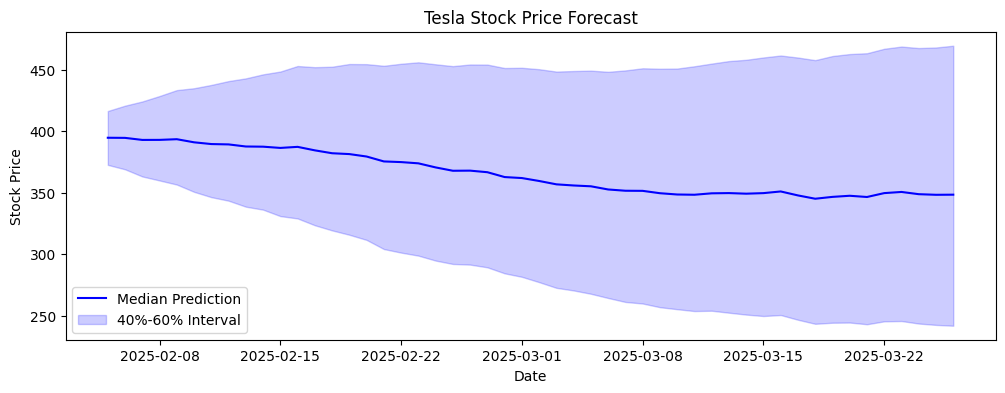

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(forecast_df["ds"], forecast_df["timesfm"], label="Median Prediction", color="blue")
plt.fill_between(
    forecast_df["ds"],
    forecast_df["timesfm-q-0.1"],
    forecast_df["timesfm-q-0.9"],
    color="blue",
    alpha=0.2,
    label="40%-60% Interval"
)
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Tesla Stock Price Forecast")
plt.legend()
plt.show()


# Predicting Tomorrow's TSLA stock price

In [14]:
from datetime import datetime, timedelta

# Generate the next day's datetime
today = datetime.today()
tmr = (today + timedelta(days=1)).date()  

# Ensure both tmr and forecast_df["ds"] are datetime
forecast_df["ds"] = pd.to_datetime(forecast_df["ds"])  # Convert to datetime
filtered_df = forecast_df[forecast_df["ds"].dt.date == tmr]  # Compare dates directly

print(filtered_df)

  unique_id                        ds     timesfm  timesfm-q-0.1  \
0      TSLA 2025-02-05 00:00:00-05:00  394.758301     372.721222   

   timesfm-q-0.2  timesfm-q-0.3  timesfm-q-0.4  timesfm-q-0.5  timesfm-q-0.6  \
0     380.867004     386.280182     390.817017     394.758301     398.523163   

   timesfm-q-0.7  timesfm-q-0.8  timesfm-q-0.9  
0     402.779785     408.088043     416.491791  


In [15]:
print(tmr)

2025-02-05


### 1. Split the data 2010-2024 - to train, 2025 to predict 

In [16]:
# TSLA_data.head()

GetTSLA = yf.Ticker("TSLA")
TSLA_data=GetTSLA.history(period="max")

train=TSLA_data.loc['2010-06-29':'2024-09-30']
test=TSLA_data.loc['2024-10-01':'2025-12-31']

train.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0
2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0
2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0
2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0
2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0


In [17]:
# the number of test, train
print(len(train), len(test))

3588 86


In [18]:
train.reset_index(inplace=True) 

#5. Build input dataframe for TimesFM
# Create the dataframe in the format required by TimesFM
input_df = pd.DataFrame({
    "unique_id": ["TSLA"] * len(train),  # Use "TSLA" as the unique identifier
    "ds": train["Date"],                # Date column
    "y": train["Close"]                 # Closing price
})


# 3. Ensure y values are 1-dimensional
# Flatten y to ensure it is a 1D array
input_df["y"] = input_df["y"].values.flatten()


# 6. Forecast using TimesFM
# Pass the input dataframe to the TimesFM model for forecasting
forecast_df = tfm.forecast_on_df(
    inputs=input_df,  # Input dataframe
    freq="D",         # Daily frequency
    value_name="y",   # The column to predict
    num_jobs=-1       # Use all available cores for parallel processing
)

# 7. Display forecast results
print(forecast_df)


Processing dataframe with multiple processes.


python(5647) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(5648) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(5649) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(5650) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(5651) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(5652) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(5653) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.


python(5654) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Loaded PyTorch TimesFM, likely because python version is 3.11.11 (main, Jan 27 2025, 15:58:08) [Clang 16.0.0 (clang-1600.0.26.6)].
Finished preprocessing dataframe.
Finished forecasting.
   unique_id                        ds     timesfm  timesfm-q-0.1  \
0       TSLA 2024-10-01 00:00:00-04:00  275.852448     255.748535   
1       TSLA 2024-10-02 00:00:00-04:00  276.640808     253.468689   
2       TSLA 2024-10-03 00:00:00-04:00  276.661835     249.919937   
3       TSLA 2024-10-04 00:00:00-04:00  275.919159     246.220856   
4       TSLA 2024-10-05 00:00:00-04:00  277.131775     244.544174   
5       TSLA 2024-10-06 00:00:00-04:00  275.677582     240.577728   
6       TSLA 2024-10-07 00:00:00-04:00  276.470886     239.495377   
7       TSLA 2024-10-08 00:00:00-04:00  274.380829     235.650177   
8       TSLA 2024-10-09 00:00:00-04:00  274.026245     232.624039   
9       TSLA 2024-10-10 00:00:00-04:00  273.762939     230.431183   
10      TSLA 2024-10-11 00:00:00-04:00  274.152618    

In [19]:
# input_df

### 2. Compare actual vs predict


In [20]:
# forecast_df["ds"]

In [21]:
# forecast_df["timesfm"]

In [22]:
# train.head()

In [23]:
# train.index = train['Date']
# train.head()

# #remove index column from train
# train.drop(columns=['index'], inplace=True)
# train.head()

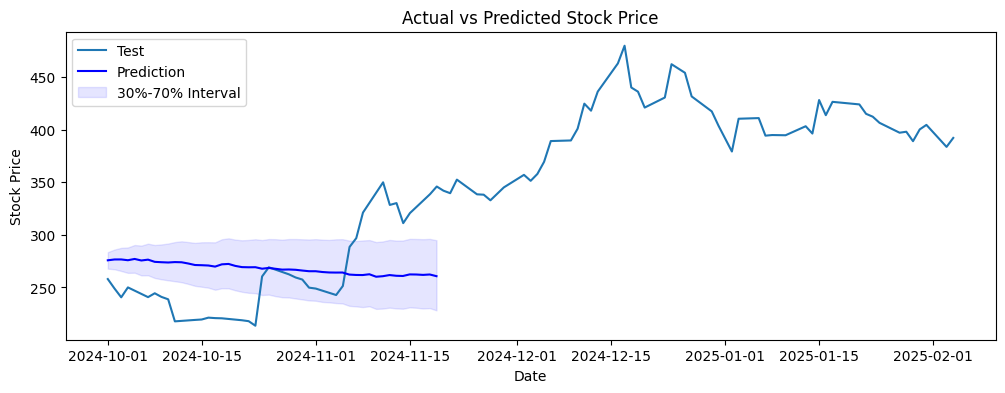

In [24]:
# Plot actual and predicted values for the test set

plt.figure(figsize=(12,4))
# plt.plot(train.index, train['Close'], label='Train')
plt.plot(test.index, test['Close'], label='Test')
plt.plot(forecast_df["ds"], forecast_df["timesfm"], label="Prediction", color="blue")
plt.fill_between(
    forecast_df["ds"],
    forecast_df["timesfm-q-0.3"],
    forecast_df["timesfm-q-0.7"],
    color="blue",
    alpha=0.1,
    label="30%-70% Interval"
)
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Price")
plt.legend()
plt.show()



In [ ]:
ctx=7
context = torch.tensor(df["price"][:-ctx])
prediction_length = ctx
forecast = pipeline.predict(context, prediction_length) 

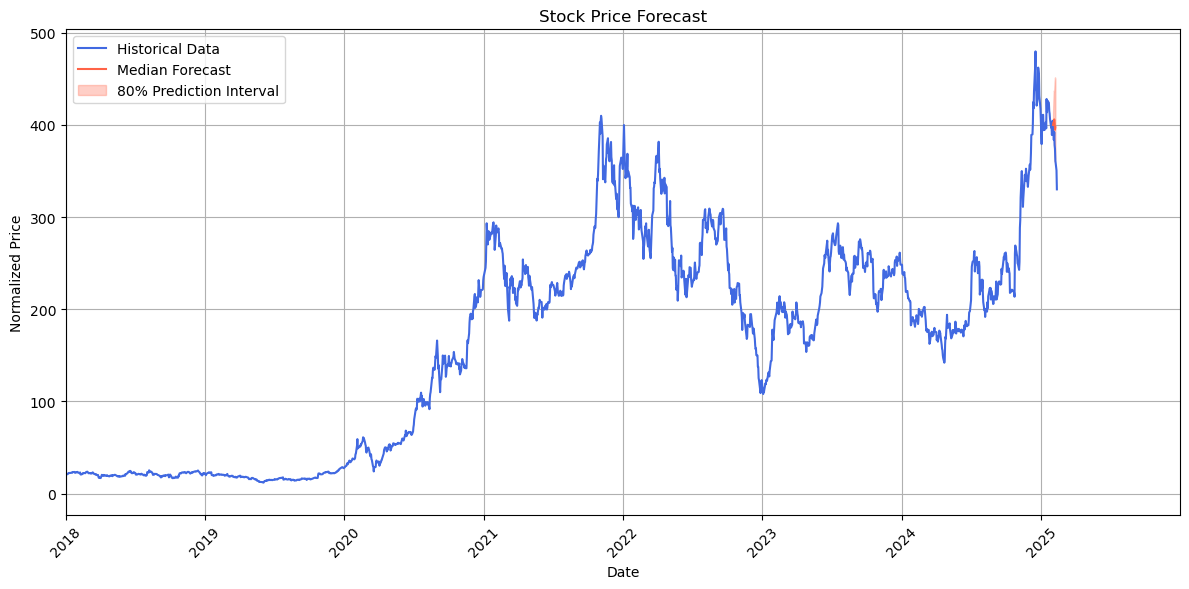

In [ ]:
# date range for the forecast
last_date = df['date'].iloc[-1-ctx]
forecast_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=1), # start from the day after the last date in the historical data
    periods=prediction_length,
    freq='D'  # daily frequency
)

plt.figure(figsize=(12, 6))
plt.plot(df["date"], df["price"], color="royalblue", label="Historical Data")
plt.plot(forecast_dates, median, color="tomato", label="Median Forecast")
plt.fill_between(forecast_dates, low, high, color="tomato", alpha=0.3, label="80% Prediction Interval")

# set x-axis(2010-01-01 ~ 2025-12-31)
plt.xlim([pd.to_datetime('2018-01-01'), pd.to_datetime('2025-12-31')])

plt.title("Stock Price Forecast")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3. performance valuation matrix ( mse, rsme, mae, r-square)

-  set the seed 
- try different seed value and check if the result is the same or not.
- improve hyperparameter (try)
- when I make the markdown note, I should know what each parameter do (taking note for everything)s

In [25]:
# forecast_df["timesfm"]

In [26]:
# test['Close']

In [27]:

# performance valuation matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Align forecast_df with test set
aligned_forecast_df = forecast_df[forecast_df["ds"].isin(test.index)]

# Calculate MSE
mse = mean_squared_error(test['Close'], aligned_forecast_df["timesfm"])

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate MAE
mae = mean_absolute_error(test['Close'], aligned_forecast_df["timesfm"])

# Calculate R2
r2 = r2_score(test['Close'], aligned_forecast_df["timesfm"])

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")


ValueError: Found input variables with inconsistent numbers of samples: [86, 24]